In [13]:
Packages <- c("dplyr","R.utils", "viridis", "splitstackshape", "data.table","ggmap", "broom","geosphere","swfscMisc", "geosphere", "fields","lattice", "ggplot2", "bbmle", "ncdf4","tidyr", "stringr", "tidyverse", "raster", "lubridate", "RColorBrewer", "data.table")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/oceanography')
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")


In [2]:
#read in data and add site names
conn_mat_all <- brick("~/oceanography/ROMS/data/Camotes_Sea_Connectivity_Matrices_08_day_PLD_integer.nc", values=T) 
#read in the data for the number of grid cells per site (site ids are North- South, as in, Palanas is number 1)
sites_n <- read.table("~/oceanography/ROMS/input//camotes_vertices_sites_results_water_only.txt", sep=" ", header=T, stringsAsFactors = F)
#the order of sites in the connectivity matrix
sites_order <- read.table("~/oceanography/ROMS/input/sites_order_as_in_roms.txt", sep=" ", header=T, stringsAsFactors = F)

sites <- as.character(c("Palanas", "Wangag", "Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop", "Hicgop South", "Sitio Tugas", "Elementary School", "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Pangasugan", "Visca", "Gabas", "Tamakin Dacot", "Haina", "Sitio Baybayon", "SF1", "SF2", "SF3", "SF4", "SF5", "SF6", "CAI", "Other"))
site_ind <- c(seq(1,28, 1))
site_id <- as.data.frame(cbind(sites, site_ind), stringsAsFactors = F)
site_id$site_ind <- as.numeric(site_id$site_ind)


[1] "vobjtovarid4: **** WARNING **** I was asked to get a varid for dimension named sink BUT this dimension HAS NO DIMVAR! Code will probably fail at this point"
[1] "vobjtovarid4: **** WARNING **** I was asked to get a varid for dimension named source BUT this dimension HAS NO DIMVAR! Code will probably fail at this point"
[1] "vobjtovarid4: **** WARNING **** I was asked to get a varid for dimension named time BUT this dimension HAS NO DIMVAR! Code will probably fail at this point"


In [3]:
#add in dates (seasons here are field seasons, not monsoon seasons)
col <- "date"
col2 <- "index"

season1 <- as.data.frame(seq(as.Date("2010/10/01"), as.Date("2011/05/31"), by="days"))
names(season1) <- col

season2 <- as.data.frame(seq(as.Date("2011/10/01"), as.Date("2012/05/31"), by="days"))
names(season2) <- col

season3 <- as.data.frame(seq(as.Date("2012/10/01"), as.Date("2013/05/31"), by="days"))
names(season3) <- col

season4 <- as.data.frame(seq(as.Date("2013/10/01"), as.Date("2014/04/18"), by="days"))
names(season4) <- col

all_dates <- bind_rows(season1, season2, season3, season4)
time_step <- as.data.frame(seq(1,930,1))
names(time_step)<- col2
all_dates2 <- bind_cols(time_step, all_dates)
dim(all_dates2)


[1] 930   2

In [4]:
#make each daily connectivity matrix into a df and then pull them all together into a list
#conn_mat_list <- vector("list", nrow(all_dates2))

#date_df <- do.call("rbind", replicate(784, date, simplify = FALSE))

conn_mat_full <- as.data.frame(matrix(nrow=0, ncol=4))

cols_conn_mat <- c("date","sink", "source", "number")
cols_tmp <- c("sink", "source", "number")

names(conn_mat_full) <- cols_conn_mat

for(i in 1:nrow(all_dates2)){
    
    index_eval <- all_dates2$index[i]
    
    tmp <- as.data.frame(conn_mat_all[[i]], xy=T)   #pull out a data frame for each date
    names(tmp) <- cols_tmp
    
    date <- filter(all_dates2, index==index_eval)[2] #grab the date
    date_df <- do.call("rbind", replicate(784, date, simplify = FALSE)) #make a df of the date
    tmp2 <- bind_cols(date_df, tmp)

 
    conn_mat_full <- rbind(conn_mat_full, tmp2) 
}



In [5]:
#connect site names
conn_mat_full2 <- left_join(conn_mat_full, site_id, by=c(source="site_ind")) %>%
    dplyr::select(-source) %>%
    rename(source="sites")
    
conn_mat_full3 <- left_join(conn_mat_full2, site_id, by=c(sink="site_ind")) %>%
    dplyr::select(-sink) %>%
    rename(dest="sites")

    

In [6]:
#make all versions of Hicgop "Hicgop South" to match empirical data
conn_mat_full3 <- conn_mat_full3 %>%
    mutate(source=ifelse(source=="Hicgop", "Hicgop South", source)) %>%
    mutate(dest=ifelse(dest=="Hicgop", "Hicgop South", dest))

#mark the monsoon seasons in which they dispersed, based on the same criteria I used for the parentage indirectly through the growth estimates
NEM <- c(11, 12, 1, 2, 3, 4, 5, 6)
SWM <- c(7, 8, 9, 10)

#add a column showing which sources and dests were empirically sampled and corresponding date/year/season data
conn_mat_full4 <- conn_mat_full3 %>%
    mutate(sim_month=month(ymd(date))) %>%
    mutate(sim_day=month(ymd(date))) %>%
    mutate(sim_year=year(ymd(date))) %>%
    mutate(year_sampled=ifelse(date %in% season1$date, "2011", ifelse(date %in% season2$date, "2012", ifelse(date %in% season3$date, "2013", "2014")))) %>%
    mutate(year_sampled=as.factor(year_sampled)) %>%
    mutate(sim_monsoon=ifelse(sim_month %in% NEM, "NEM", "SWM")) %>%
    rename(daily_particles_rec="number") %>%
    relocate(daily_particles_rec,.after=sim_monsoon)
    

 

In [8]:
head(conn_mat_full4)

date,source,dest,sim_month,sim_day,sim_year,year_sampled,sim_monsoon,daily_particles_rec
2010-10-01,Other,Palanas,10,10,2010,2011,SWM,9
2010-10-01,Other,Wangag,10,10,2010,2011,SWM,4
2010-10-01,Other,Magbangon,10,10,2010,2011,SWM,11
2010-10-01,Other,Cabatoan,10,10,2010,2011,SWM,12
2010-10-01,Other,Caridad Cemetery,10,10,2010,2011,SWM,0
2010-10-01,Other,Caridad Proper,10,10,2010,2011,SWM,1


In [9]:
#fwrite(conn_mat_full4, file="~/oceanography/script_output/ROMSDataTables/SimConnectivityTable08DayPLD.csv")
#fwrite(conn_mat_full4, file="~/oceanography/script_output/ROMSDataTables/SimConnectivityTable.gz")#this doesn't actually compress dangit.


In [ ]:
###06/07/2021
#Maybe plug in the metadata adding code from optimize_roms here?

__Skip above and read the tidied data frame below__

In [2]:
#head(conn_mat_full4)
SimConnDF <- read.csv(file="~/oceanography/script_output/ROMSDataTables/SimConnectivityTable08DayPLD.csv", header=T) %>%
    mutate(year_sampled=as.character(year_sampled))
#make vectors defining sites we didn't sample, but that are in the model, and the sandflats specifically 
unsampled_sites <- c("SF1", "SF2", "SF3", "SF4", "SF5", "SF6", "Pangasugan", "Other", "CAI") 
sand_flats <- c("SF1", "SF2", "SF3", "SF4", "SF5", "SF6") 
unrealistic_sources <- c("SF1", "SF2", "SF3", "SF4", "SF5", "SF6", "Pangasugan") 

#add in the numbers of particles seeded at each site
SeededParticles <- read.csv("~/oceanography/ROMS/data/Particles_Per_Release_Site_Renamed.csv", header=F)
col <- c("site", "daily_particles_released")
colnames(SeededParticles) <- col
SimConnDF <- left_join(SimConnDF, SeededParticles, by=c(source="site")) 

In [3]:
head(SimConnDF)

date,source,dest,sim_month,sim_day,sim_year,year_sampled,sim_monsoon,daily_particles_rec,daily_particles_released
2010-10-01,Other,Palanas,10,10,2010,2011,SWM,13,4497728
2010-10-01,Other,Wangag,10,10,2010,2011,SWM,7,4497728
2010-10-01,Other,Magbangon,10,10,2010,2011,SWM,10,4497728
2010-10-01,Other,Cabatoan,10,10,2010,2011,SWM,10,4497728
2010-10-01,Other,Caridad Cemetery,10,10,2010,2011,SWM,52,4497728
2010-10-01,Other,Caridad Proper,10,10,2010,2011,SWM,132,4497728


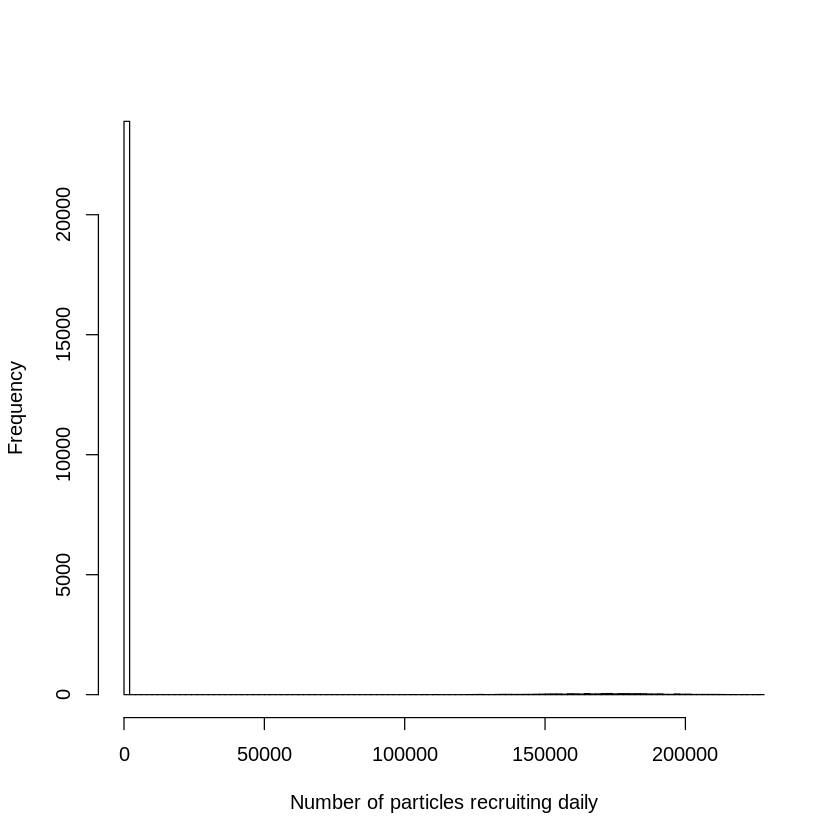

In [16]:
##check that everything looks correct
#test <- SimConnDF %>% filter(daily_particles_rec >1 & 
#                             source_sampled=="yes" & dest_sampled=="yes")
##pdf("~/oceanography/figures/HistNumParticlesRecruiting.pdf")
#hist(test$daily_particles_rec, breaks=100, xlab="Number of particles recruiting daily", main=NULL)
##dev.off()


In [3]:
##put in North-South order for kernel fitting, also used for GLM connectivity data frame?
SitesNS <- read.csv("~/parentage/text_file/sites_NS.txt", stringsAsFactors = F) %>%
    mutate(site=ifelse(site =="S. Magbangon" , "Magbangon", site)) %>%
    filter(site != "N. Magbangon") 

###add site size - is this worth adding? It would be a random effect, I already know that it affects the number of particles...
##Reef_sizes <- read.csv("~/parentage/kernel_fitting/894_loci/area_unsurveyed.", header=FALSE)

#add the distances between sites, calculated from the site centroids
centroidsSamp <- read.csv("~/parentage/kernel_fitting/1340_loci/input/site_centroids.csv", header=TRUE, stringsAsFactors = F) %>%
    mutate(site=ifelse(site =="S.Magbangon" , "Magbangon", site)) %>%
    filter(site != "N.Magbangon") %>%
    filter(site %in% SitesNS$site)

#I want to average the Camotes Islands values and add those in. That way I can use that distance in the GLM of the simulated ROMS as response variable. this can be subsetted out for the observed data by using the "source/dests sampled" columns
#pull out the camotes centroids for a df with just them, to average lat/lon points with (centroids)
CAI <- c("camotes_central1", "camotes_central2", "camotes_east1", "camotes_east2", "camotes_west1", "camotes_west2")

centroidsSim <- read.csv("~/parentage/kernel_fitting/1340_loci/input/site_centroids.csv", header=TRUE, stringsAsFactors =F)
CamotesAvg <- centroidsSim %>%
    filter(site %in% CAI) %>%
    mutate(lon=mean(lon)) %>% #take the average lon
    mutate(lat=mean(lat)) %>% #take the average lat
    slice_head()

CamotesAvg$site <- "CAI"#make a one row DF for this value that can be added to centroids so it's distances are calculated

#add to tidy distance
centroids <- bind_rows(centroidsSamp, CamotesAvg) 

#add in the sand flats to the centroids, using the average location in the ROMS vertices
SandFlats <- c("Sand_Flat1", "Sand_Flat2", "Sand_Flat3", "Sand_Flat4", "Sand_Flat5", "Sand_Flat6")
SFROMSVerts <-read.table("~/oceanography/ROMS//input/camotes_vertices_sites_results_water_only.txt", sep=" ", header=T) %>%
    group_by(site) %>%
    summarise(AvgOneLon=mean(one_lon), AvgTwoLon=mean(two_lon), AvgThreeLon=mean(three_lon), AvgFourLon=mean(four_lon),
             AvgOneLat=mean(one_lat), AvgTwoLat=mean(two_lat), AvgThreeLat=mean(three_lat), AvgFourLat=mean(three_lat)) %>%
    gather(LonVertice, LonValue, 2:5) %>% # make all of the longitudes a key value combination
    gather(LatVertice, LatValue, 2:5) %>%# make all of the latitudes a key value combination
    filter(site %in% SandFlats)#retain only the sand flat locations

#average the sand flat vertices

SFAvg <- left_join(SFROMSVerts %>% 
                         group_by(site) %>%
                        summarise(AvgLon=mean(LonValue)),
                        SFROMSVerts %>% 
                         group_by(site) %>%
                        summarise(AvgLat=mean(LatValue)), by="site") %>%
                        mutate(site=str_replace(site, "Sand_Flat", "SF")) %>% #replace Sand_Flat with SF to match later code
                        rename(lat="AvgLat", lon="AvgLon") #rename columns to match centroids
#add into centroids
centroids <- bind_rows(centroids, SFAvg) 


all_possible_dists <- as.data.frame(rdist.earth(as.matrix(centroids[,c('lon', 'lat')]), as.matrix(centroids[,c('lon', 'lat')]), miles=FALSE, R=6371))

##attach the sample_ids to each distance, so you can also get site and year
colnames(all_possible_dists) <- centroids$site
all_possible_dists$site_i <- centroids$site

##gather into tidy df
all_possible_dists_tidy <- all_possible_dists %>%
    dplyr::select(site_i, everything()) %>%
    gather(2:26, key=site_j, value=dist_km) 
nrow(all_possible_dists_tidy)


SimConnDFDist <- left_join(SimConnDF, all_possible_dists_tidy, by=c(source="site_i", dest="site_j"))

#write out the combined centroids file and distances file, these will be used in kernel fitting for simulation
#write.csv(centroids, file="~/oceanography/script_output/SurveyData/SimulationCentroids.csv", row.names=F)
#write.csv(all_possible_dists_tidy, file="~/oceanography/script_output/SurveyData/SimulationAllDistances.csv", row.names=F)



`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)
`summarise()` ungrouping output (override with `.groups` argument)


[1] 625

In [21]:
head(SitesNS)

site,index
Palanas,1
Wangag,2
Magbangon,4
Cabatoan,5
Caridad Cemetery,6
Caridad Proper,7


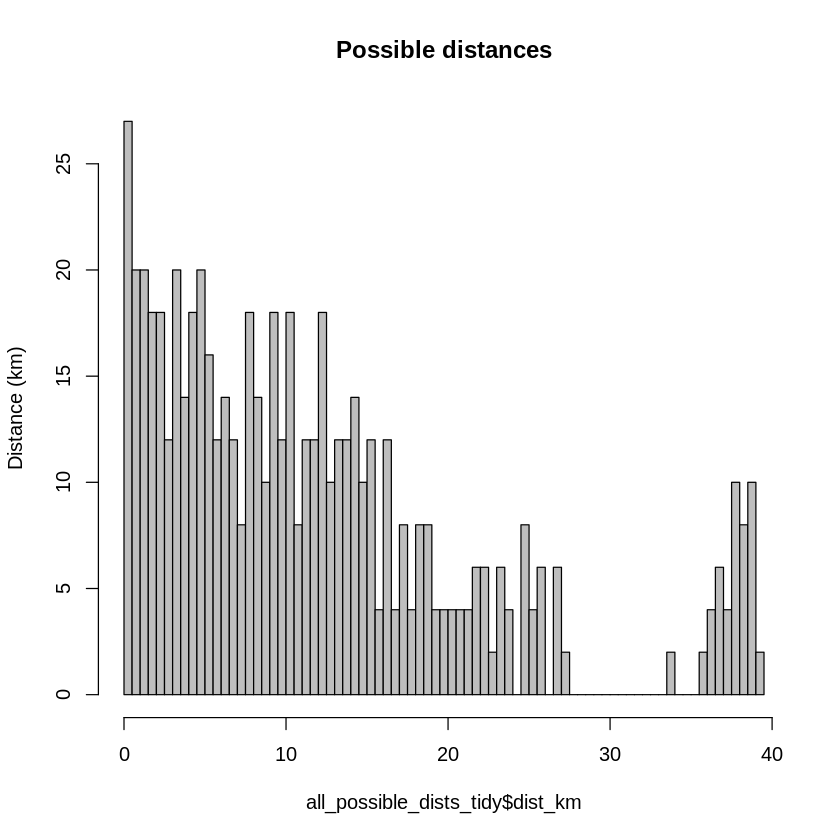

In [5]:
#png("~/oceanography/figures/HistPossibleDistances.png")
hist(all_possible_dists_tidy$dist_km, breaks=70, main="Possible distances", ylab="Distance (km)", col="gray")
#dev.off()

In [4]:


#add a continuous value for direction in the form of a bearing
#col <- c("site_i", "site_j", "bearing")
AllBearings <- matrix(nrow=0, ncol=3)
#colnames(AllBearings) <- col

for(i in 1:nrow(centroids)) {
    
    site_i <- centroids[i,] #take the site name
    site_i_coords <- as.matrix(site_i[,2:3]) #get the lon/lat

    #now compare this site to all other sites for bearing
    
    bearings <- matrix(nrow=nrow(centroids), ncol=3)

    for(j in 1:nrow(centroids)){
        


        site_j <- centroids[j,]
        site_j_coords <- as.matrix(site_j[,2:3]) #get the lon/lat

        bearing <- geosphere::bearing(site_i_coords, site_j_coords)
        bearings[j,1] <- site_i[1,1] #add to data frame
        bearings[j,2] <- site_j[1,1]
        bearings[j,3] <- as.character(bearing)

    }
    AllBearings <- rbind(AllBearings, bearings)

}
nrow(AllBearings)#should be 625
nrow(centroids)
25*25

col <- c("site_i", "site_j", "bearing")
AllBearings <- as.data.frame(AllBearings)
colnames(AllBearings) <- col

AllBearings <- AllBearings %>%
        mutate(site_i=as.character(site_i)) %>%
        mutate(site_j=as.character(site_j)) %>%
        mutate(bearing=as.numeric(as.character(bearing))) %>%
        #mutate(bearing=ifelse(bearing==-180, -1, bearing)) %>% #for self-recruitment routes
        mutate(direction=(bearing+360)%% 360) %>% # from https://stackoverflow.com/questions/51030060/in-geosphere-package-in-r-why-arent-bearings-in-0-360-degrees
        mutate(direction=ifelse(site_i==site_j, -10, direction)) #for self-recruitment routes

#write.csv(AllBearings, file="~/oceanography/script_output/SurveyData/AllBearings.csv", row.names=F)

SimConnDFDir <- left_join(SimConnDFDist, AllBearings, by=c(source="site_i", dest="site_j")) 

#write.csv(SimConnDFDir, file="~/oceanography/script_output/ROMSDataTables/SimConnectivityTableWithMeta08DayPLD.csv", row.names=F)

[1] 625

[1] 25

[1] 625

In [20]:
-1 + 360 %% 360

[1] -1

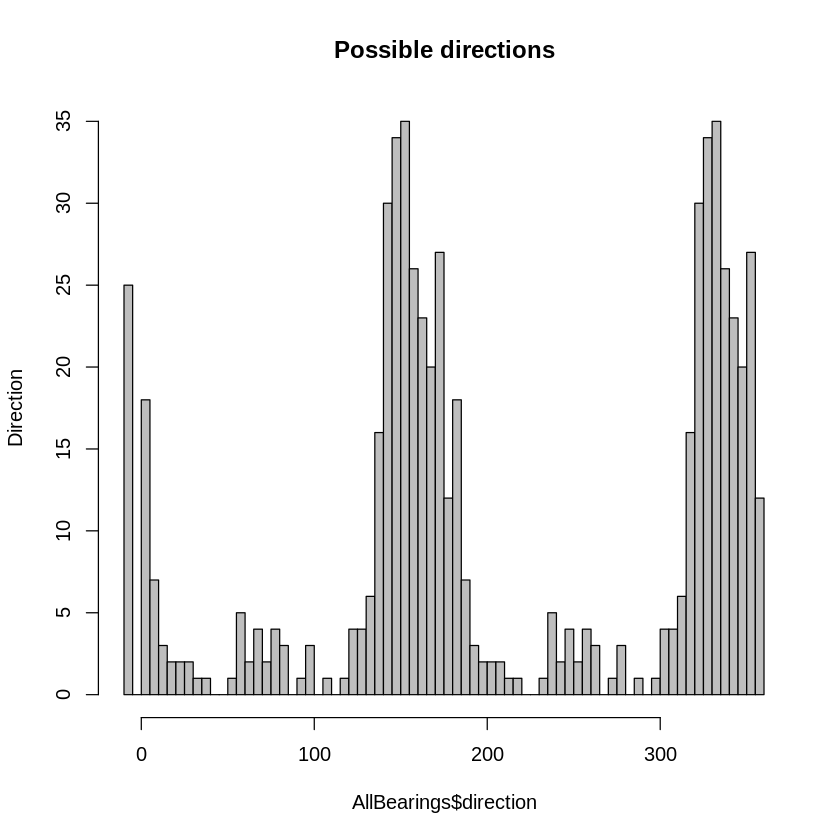

In [21]:
#png("~/oceanography/figures/HistPossibleDirections.png")
hist(AllBearings$direction, breaks=70, main="Possible directions", ylab="Direction", col="gray")
#dev.off()

In [15]:
str(SimConnDFDir)
unsampled_sites

'data.frame':	729120 obs. of  13 variables:
 $ date                    : Factor w/ 930 levels "2010-10-01","2010-10-02",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ source                  : chr  "Other" "Other" "Other" "Other" ...
 $ dest                    : chr  "Palanas" "Wangag" "Magbangon" "Cabatoan" ...
 $ sim_month               : int  10 10 10 10 10 10 10 10 10 10 ...
 $ sim_day                 : int  10 10 10 10 10 10 10 10 10 10 ...
 $ sim_year                : int  2010 2010 2010 2010 2010 2010 2010 2010 2010 2010 ...
 $ year_sampled            : chr  "2011" "2011" "2011" "2011" ...
 $ sim_monsoon             : Factor w/ 2 levels "NEM","SWM": 2 2 2 2 2 2 2 2 2 2 ...
 $ daily_particles_rec     : int  9 4 11 12 0 1 0 0 22 11 ...
 $ daily_particles_released: int  4497728 4497728 4497728 4497728 4497728 4497728 4497728 4497728 4497728 4497728 ...
 $ dist_km                 : num  NA NA NA NA NA NA NA NA NA NA ...
 $ bearing                 : num  NA NA NA NA NA NA NA NA NA NA ...
 $ directio

[1] "SF1"        "SF2"        "SF3"        "SF4"        "SF5"       
[6] "SF6"        "Pangasugan" "Other"      "CAI"

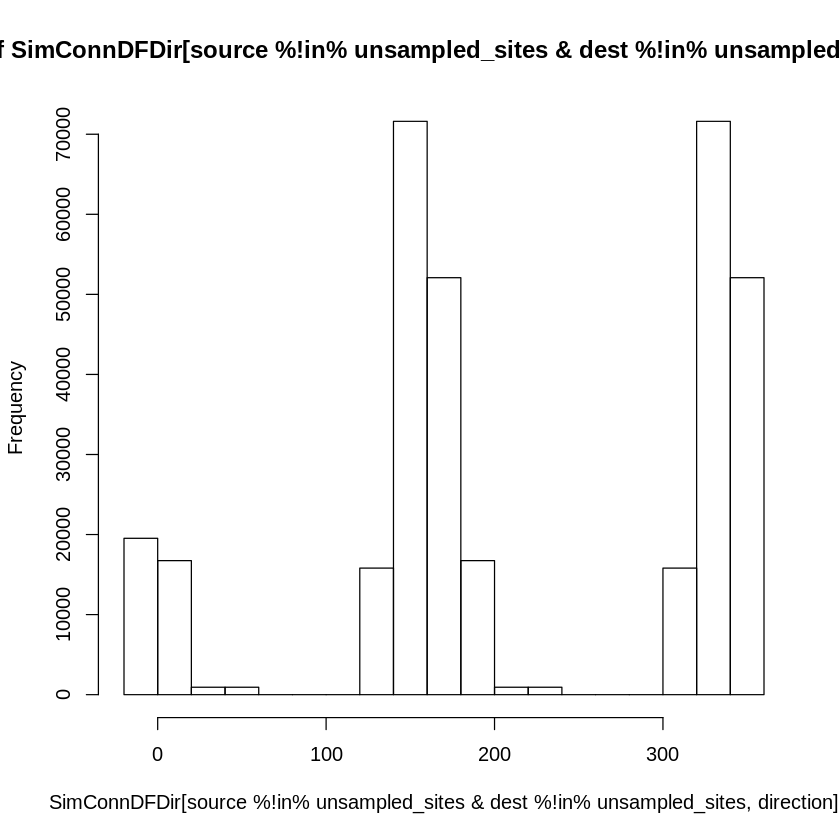

In [19]:
hist(SimConnDFDir[source %!in% unsampled_sites & dest %!in% unsampled_sites, direction])

In [18]:
unsampled_sites <- c("SF1", "SF2", "SF3", "SF4", "SF5", "SF6", "Pangasugan", "Other", "CAI") 
setDT(SimConnDFDir)
test_mod <- glm(data=SimConnDFDir[source %!in% unsampled_sites & dest %!in% unsampled_sites], daily_particles_rec ~ dist_km+direction+sim_monsoon, famil="poisson")
summary(test_mod)


Call:
glm(formula = daily_particles_rec ~ dist_km + direction + sim_monsoon, 
    family = "poisson", data = SimConnDFDir[source %!in% unsampled_sites & 
        dest %!in% unsampled_sites])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
 -4.088   -2.123   -1.431   -0.854  102.804  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)     2.098e+00  2.102e-03   998.0   <2e-16 ***
dist_km        -1.475e-01  2.944e-04  -500.8   <2e-16 ***
direction      -2.480e-03  1.056e-05  -234.8   <2e-16 ***
sim_monsoonSWM -7.458e-01  5.021e-03  -148.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 4674713  on 335729  degrees of freedom
Residual deviance: 4102696  on 335726  degrees of freedom
AIC: 4212841

Number of Fisher Scoring iterations: 9


In [15]:
#make the connectivity data long form
setDT(SimConnDFDir)
SimConn <- SimConnDFDir[dest !="Other" & source %!in% unrealistic_sources] #we don't care about "other" as a destination, and sand flats etc can't be a source
check1 <- sum(SimConn$daily_particles_rec)   
#setkey(SimConn, source)
SimConn <- SimConn[rep(seq_len(nrow(SimConn)), SimConn$daily_particles_rec), 1:ncol(SimConn)][ #make long form, repeat each row the number of times specified in "DailyParticles"
    , particle_id := paste ("P", .I, sep = "", collapse = NULL)]#finally, make a new column that's the particle ID for each row

nrow(SimConn)==check1 #should be TRUE, meaning the correct number of particles are retained

#fwrite(SimConn, file="~/oceanography/script_output/ROMSDataTables/SimConnectivityTableWithMetaLongForm08DayPLD.csv", row.names=F)

[1] TRUE

In [44]:
nrow(SimConn)

[1] 212791371

In [91]:
#plot the simulated connectivity matrices, but just don't normalized by source release number. Instead, make this a SR table, where it shows the number of particles, period. So a visual representation of the biophysical parentage assignments
unsampled_sites <- c("SF1", "SF2", "SF3", "SF4", "SF5", "SF6", "Pangasugan", "Other", "CAI") 

#define a CV function
cv <- function(x){
    sd(x)/mean(x)
}


SimConnAllYearSummary <- fread(file="~/oceanography/script_output/ROMSDataTables/SimConnectivityTableWithMeta08DayPLD.csv")[year_sampled != 2011 & dest %!in% unsampled_sites & source %!in% unsampled_sites][ 
    , .(total_rec = sum(daily_particles_rec)), by=c("source", "dest")][#raw number of recruits
    , total_prop := total_rec/sum(total_rec)]   #as the proportion of all particles recruiting to the study region in that time period                                                                                                       

SimConnAnnualSummary <- fread(file="~/oceanography/script_output/ROMSDataTables/SimConnectivityTableWithMeta08DayPLD.csv")[year_sampled != 2011 & dest %!in% unsampled_sites & source %!in% unsampled_sites][ 
    , .(annual_rec = sum(daily_particles_rec)), by=c("year_sampled", "source", "dest")][#raw number of recruits
    , annual_prop := annual_rec/sum(annual_rec), by=c("year_sampled")][   #as the proportion of all particles recruiting to the study region in that time period                                                                                                       
    , cv_prop := cv(annual_prop), by=c("source", "dest")][
    , annual_prop_of_total :=annual_rec/sum(annual_rec)] #as the proportion of all particles recruiting to the study region from 2012-2014
SimConnMonsoonSummary <- fread(file="~/oceanography/script_output/ROMSDataTables/SimConnectivityTableWithMeta08DayPLD.csv")[year_sampled != 2011 & dest %!in% unsampled_sites & source %!in% unsampled_sites][ 
    , .(monsoon_rec = sum(daily_particles_rec)), by=c("sim_monsoon", "source", "dest")][#raw number of recruits
    , monsoon_prop := monsoon_rec/sum(monsoon_rec), by=c("sim_monsoon")][   #as the proportion of all particles recruiting to the study region in that time period   
    , cv_prop := cv(monsoon_prop), by=c("source", "dest")]

In [99]:

sum(SimConnAnnualSummary[year_sampled==2012, annual_prop_of_total]) 
sum(SimConnAnnualSummary[year_sampled==2013, annual_prop_of_total])
sum(SimConnAnnualSummary[year_sampled==2014, annual_prop_of_total])

[1] 0.3577011

[1] 0.3126351

[1] 0.3296639

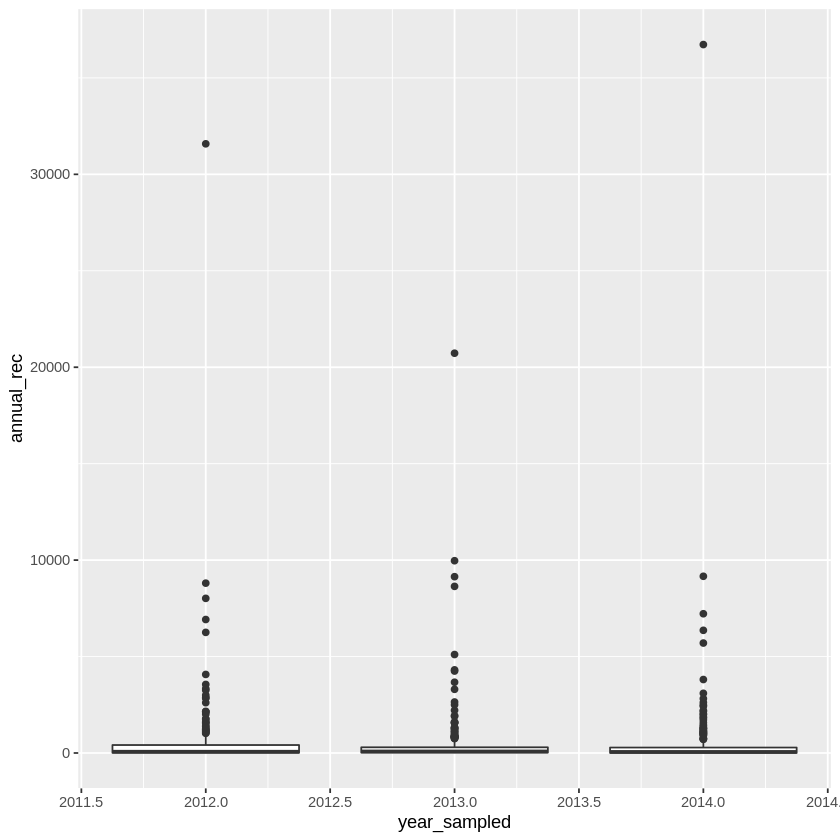

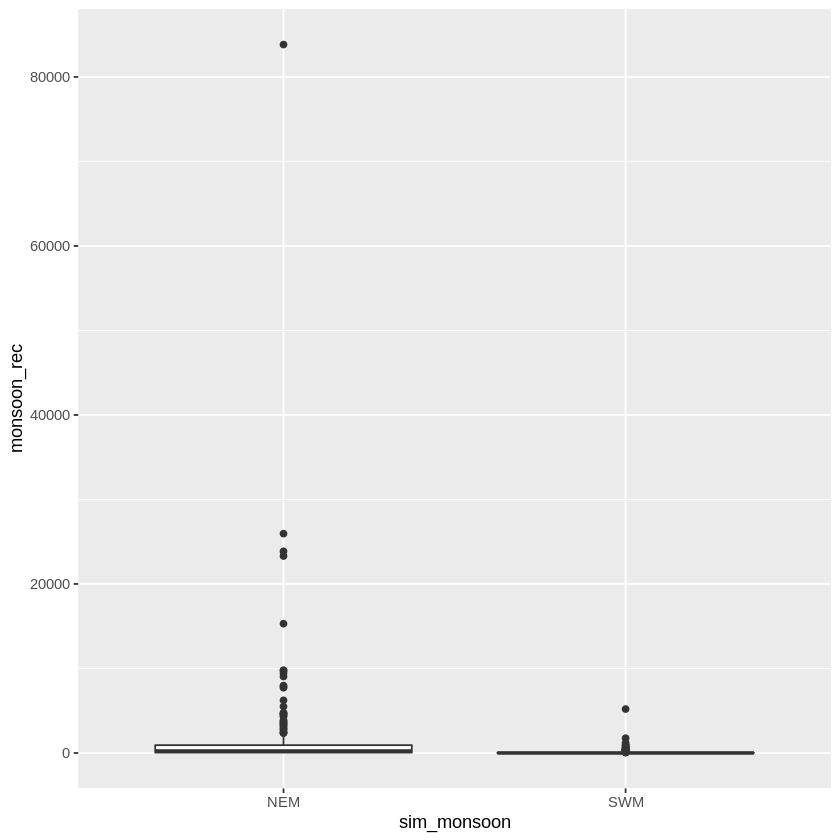

In [90]:
ggplot()+
    geom_boxplot(data=SimConnAnnualSummary, aes(x=year_sampled, y=annual_rec, group=year_sampled))

ggplot()+
    geom_boxplot(data=SimConnMonsoonSummary, aes(x=sim_monsoon, y=monsoon_rec, group=sim_monsoon))

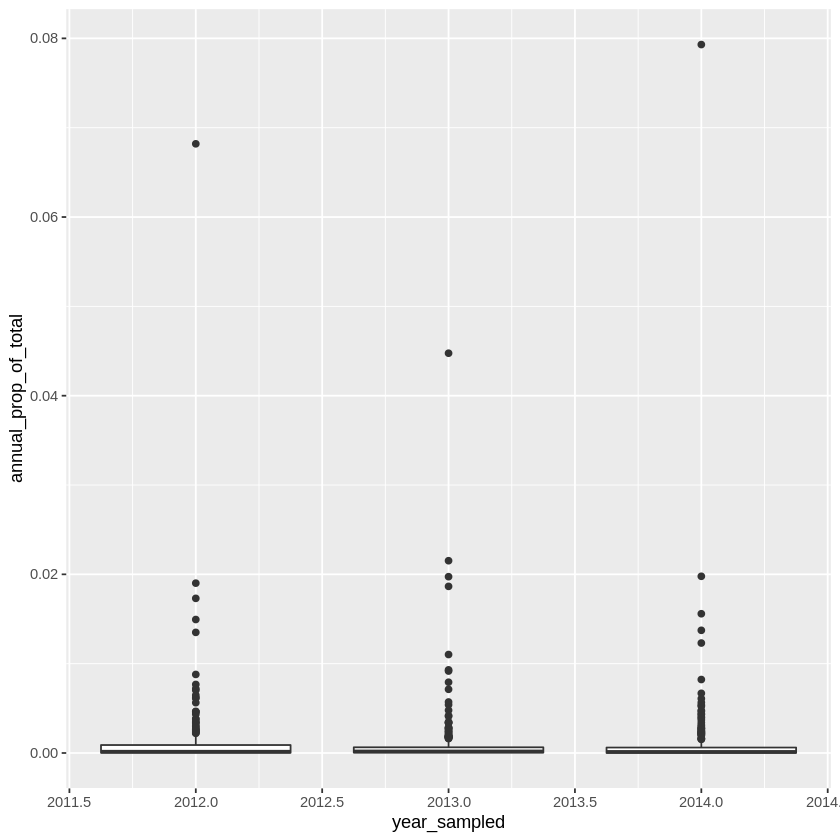

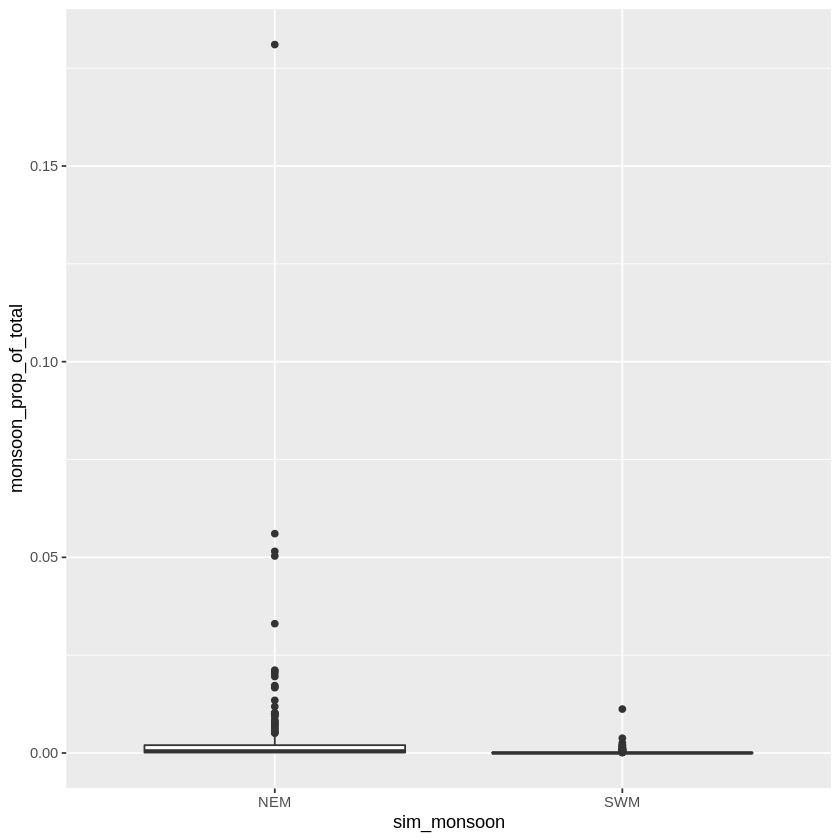

In [92]:
ggplot()+
    geom_boxplot(data=SimConnAnnualSummary, aes(x=year_sampled, y=annual_prop_of_total, group=year_sampled))

ggplot()+
    geom_boxplot(data=SimConnMonsoonSummary, aes(x=sim_monsoon, y=monsoon_prop_of_total, group=sim_monsoon))

Saving 6.67 x 6.67 in image


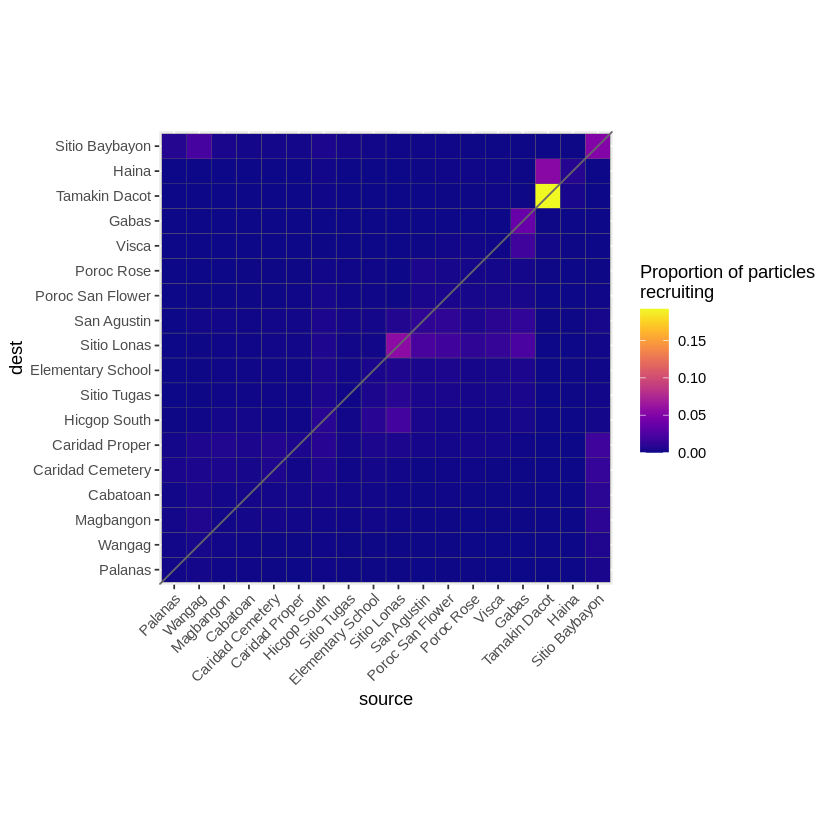

In [59]:
SimConnAllYearSummary$source <-factor(SimConnAllYearSummary$source, levels=c("Palanas", "Wangag",  "Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop South",  "Sitio Tugas", "Elementary School",  "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Visca",  "Gabas",  "Tamakin Dacot", "Haina", "Sitio Baybayon"))
SimConnAllYearSummary$dest <-factor(SimConnAllYearSummary$dest, levels=c("Palanas", "Wangag", "Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop South",  "Sitio Tugas", "Elementary School", "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Visca", "Gabas", "Tamakin Dacot", "Haina", "Sitio Baybayon"))

AllYear <- ggplot(SimConnAllYearSummary, aes(source, dest)) + 
    geom_tile(aes(fill = total_prop), color = "grey40")+
    coord_fixed(ratio = 1) +
    theme(axis.text.x=element_text(angle=45,hjust=1))+
    scale_fill_viridis(option="plasma", name="Proportion of particles \nrecruiting") +
    geom_abline(slope=1,color = "grey40")
AllYear
#ggsave(filename="SimmConnMatAllYears.png", plot= AllYear, path="~/oceanography/script_output/plots/" )


Saving 6.67 x 6.67 in image


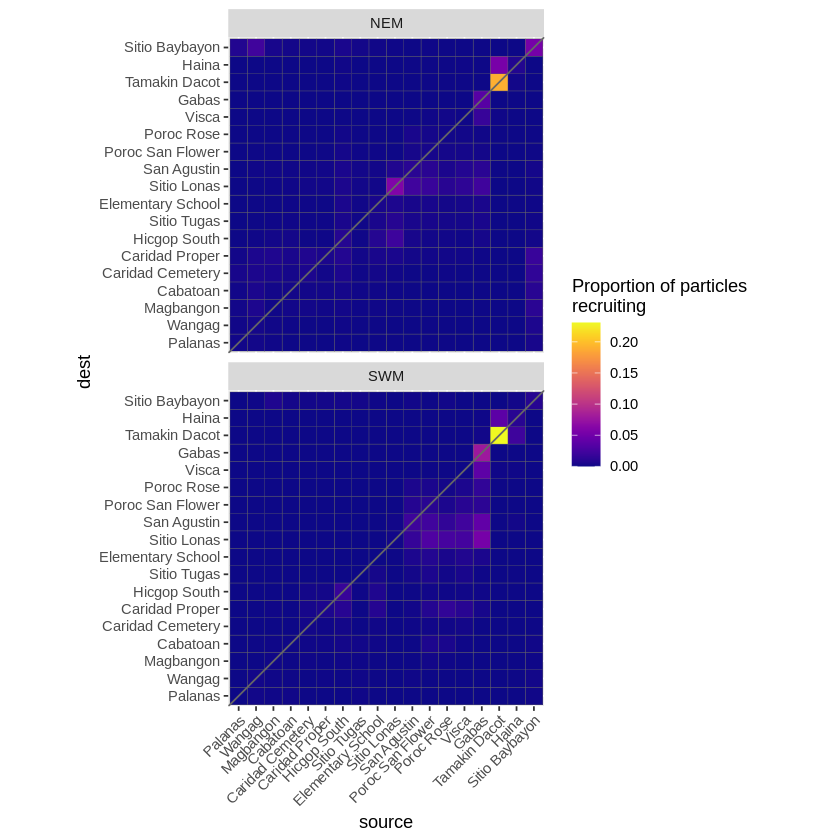

In [65]:
SimConnMonsoonSummary$source <-factor(SimConnMonsoonSummary$source, levels=c("Palanas", "Wangag",  "Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop South",  "Sitio Tugas", "Elementary School",  "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Visca",  "Gabas",  "Tamakin Dacot", "Haina", "Sitio Baybayon"))
SimConnMonsoonSummary$dest <-factor(SimConnMonsoonSummary$dest, levels=c("Palanas", "Wangag", "Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop South",  "Sitio Tugas", "Elementary School", "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Visca", "Gabas", "Tamakin Dacot", "Haina", "Sitio Baybayon"))


Monsoon <- ggplot(SimConnMonsoonSummary, aes(source, dest)) + 
    geom_tile(aes(fill = monsoon_prop), color = "grey40")+
    coord_fixed(ratio = 1) +
    theme(axis.text.x=element_text(angle=45,hjust=1))+
    scale_fill_viridis(option="plasma", name="Proportion of particles \nrecruiting") +
    geom_abline(slope=1,color = "grey40")+
    facet_wrap(~ sim_monsoon, ncol=1)
Monsoon
#ggsave(filename="SimmConnMatMonsoons.png", plot= Monsoon, path="~/oceanography/script_output/plots/" )


Saving 6.67 x 6.67 in image


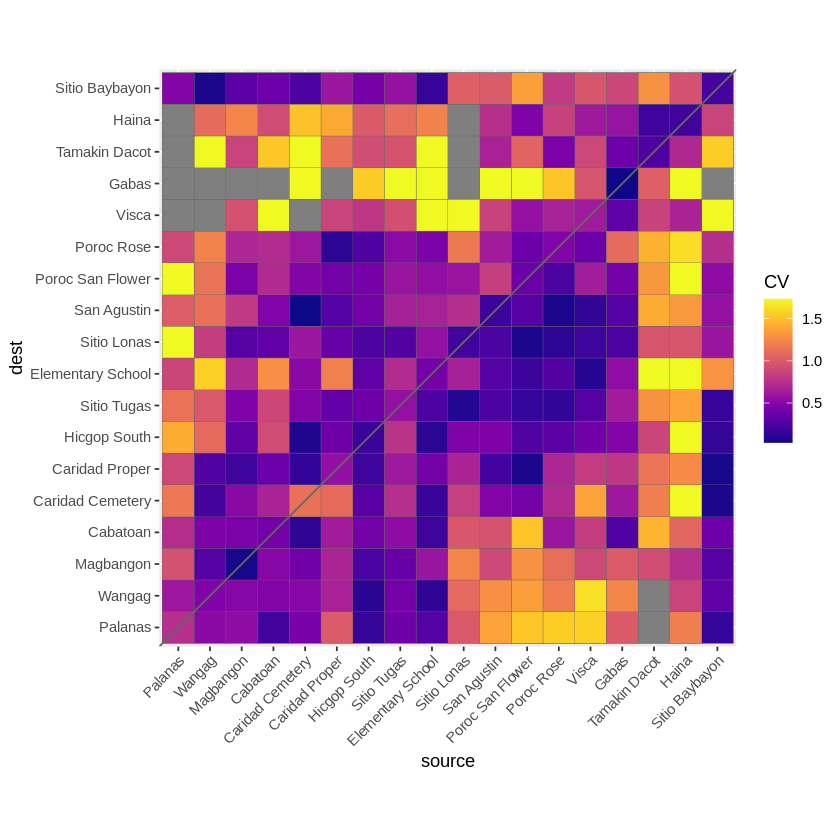

In [79]:
SimConnAnnualSummary$source <-factor(SimConnAnnualSummary$source, levels=c("Palanas", "Wangag",  "Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop South",  "Sitio Tugas", "Elementary School",  "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Visca",  "Gabas",  "Tamakin Dacot", "Haina", "Sitio Baybayon"))
SimConnAnnualSummary$dest <-factor(SimConnAnnualSummary$dest, levels=c("Palanas", "Wangag", "Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop South",  "Sitio Tugas", "Elementary School", "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Visca", "Gabas", "Tamakin Dacot", "Haina", "Sitio Baybayon"))

AllYearCV <- ggplot(SimConnAnnualSummary, aes(source, dest)) + 
    geom_tile(aes(fill = cv_prop), color = "grey40")+
    coord_fixed(ratio = 1) +
    theme(axis.text.x=element_text(angle=45,hjust=1))+
    scale_fill_viridis(option="plasma", name="CV") +
    geom_abline(slope=1,color = "grey40")
AllYearCV
#ggsave(filename="SimmConnMatAllYearsCV.png", plot= AllYearCV, path="~/oceanography/script_output/plots/" )


Saving 6.67 x 6.67 in image


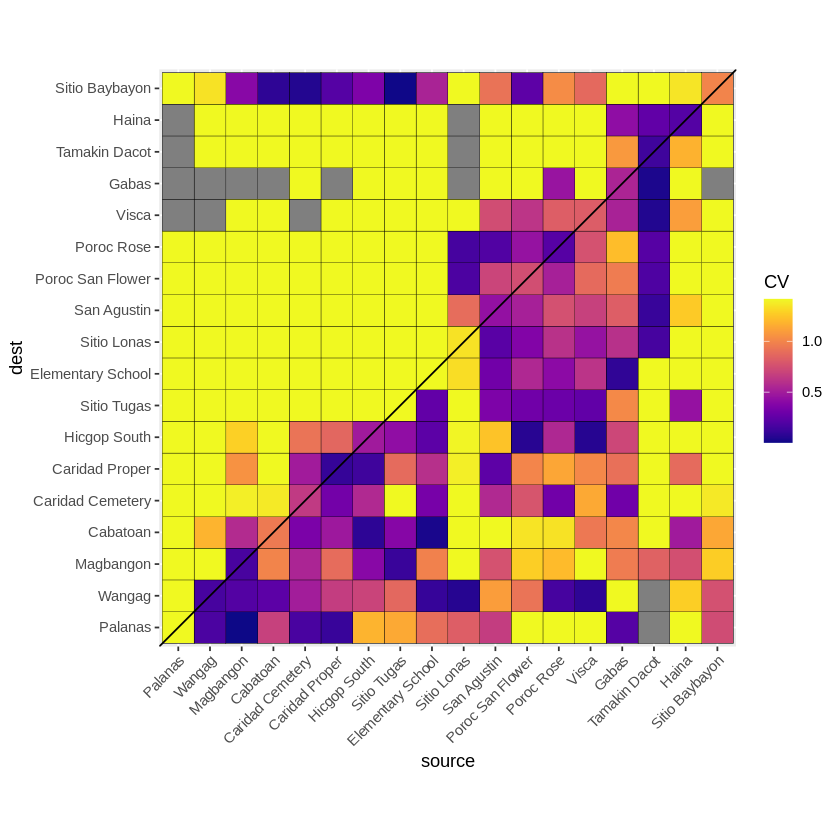

In [76]:
#plot cv on monsoon and annual time scales
SimConnMonsoonSummary$source <-factor(SimConnMonsoonSummary$source, levels=c("Palanas", "Wangag",  "Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop South",  "Sitio Tugas", "Elementary School",  "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Visca",  "Gabas",  "Tamakin Dacot", "Haina", "Sitio Baybayon"))
SimConnMonsoonSummary$dest <-factor(SimConnMonsoonSummary$dest, levels=c("Palanas", "Wangag", "Magbangon", "Cabatoan", "Caridad Cemetery", "Caridad Proper", "Hicgop South",  "Sitio Tugas", "Elementary School", "Sitio Lonas", "San Agustin", "Poroc San Flower", "Poroc Rose", "Visca", "Gabas", "Tamakin Dacot", "Haina", "Sitio Baybayon"))

MonsoonCV <- ggplot(SimConnMonsoonSummary, aes(source, dest)) + 
    geom_tile(aes(fill = cv_prop), color = "grey40")+
    coord_fixed(ratio = 1) +
    theme(axis.text.x=element_text(angle=45,hjust=1))+
    scale_fill_viridis(option="plasma", name="CV") +
    geom_abline(slope=1,color = "grey40")

MonsoonCV
#ggsave(filename="SimmConnMatMonsoonCV.png", plot= MonsoonCV, path="~/oceanography/script_output/plots/" )


In [41]:
AllSitesPar <- left_join(test, ObsDisp, by=c(source="par_site", dest="offs_site")) %>%
    dplyr::select(-year) %>%
    mutate(obs_disp=ifelse(is.na(obs_disp), 0, obs_disp)) %>%
    group_by(source, dest) %>%
    summarise(TotalObsDisp=sum(obs_disp))
sum(AllSitesPar$TotalObsDisp)

`summarise()` regrouping output by 'source' (override with `.groups` argument)


[1] 49

In [43]:
#parentage observations

AnnualParentage <- ggplot(AllSitesPar, aes(source, dest)) + #filter sim_year=="SWM" & 
    geom_tile(aes(fill = TotalObsDisp), color = "grey40")+
    coord_fixed(ratio = 1) +
    theme(axis.text.x=element_text(angle=45,hjust=1))+
    scale_fill_viridis(option="viridis", name="Total observations") +
ggtitle("Parentage 2012-2018")
#AnnualParentage
#ggsave(filename="AnnualParentage.png", plot=AnnualParentage, path="~/oceanography/figures")
